In [157]:
#Imports
import sys, os
redux_directory = '/Users/catherinemanea/Box/GalArchLab/TullRedux/'
sys.path.insert(0, os.path.abspath(redux_directory))
import importlib
importlib.reload(redux)

import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

Redux.py successfully loaded in.




Start by accumulating your files using "glob" or any similar tool:

In [158]:
bias_files = glob.glob("/Users/catherinemanea/Box/GalArchLab/Data/Obs/HVS_obs/UT190401/Bias*.fits")
flat_files = glob.glob("/Users/catherinemanea/Box/GalArchLab/Data/Obs/HVS_obs/UT190401/Flat*.fits")
obj_files = np.array(["/Users/catherinemanea/Box/GalArchLab/Data/Obs/HVS_obs/UT190401/Star0001.fits", "/Users/catherinemanea/Box/GalArchLab/Data/Obs/HVS_obs/UT190401/Star0002.fits"])
thar_files = glob.glob("/Users/catherinemanea/Box/GalArchLab/Data/Obs/HVS_obs/UT190401/ThAr*.fits")
sun_files = glob.glob("/Users/catherinemanea/Box/GalArchLab/Data/Obs/HVS_obs/UT190401/solar*.fits")

Extract data + header info (data will be stacks of 2-d arrays, one per exposure)

In [159]:
bias_headers, bias_data, bias_objs, bias_dates, bias_exps = redux.fits_to_img(bias_files)
flat_headers, flat_data, flat_objs, flat_dates, flat_exps = redux.fits_to_img(flat_files)
obj_headers, obj_data, obj_objs, obj_dates, obj_exps = redux.fits_to_img(obj_files)
thar_headers, thar_data, thar_objs, thar_dates, thar_exps = redux.fits_to_img(thar_files)
sun_headers, sun_data, sun_objs, sun_dates, sun_exps = redux.fits_to_img(sun_files)

Finished extracting zero file(s)
Finished extracting flat file(s)
Finished extracting HD84937 file(s)
Finished extracting ThAr file(s)
Finished extracting Solar Port file(s)


Make your bias and flat frames

In [160]:
bias_frame = redux.make_bias(bias_data)
flat_frame_intermed = redux.make_flat(flat_data, flat_exps, bias_frame)

<IPython.core.display.Javascript object>


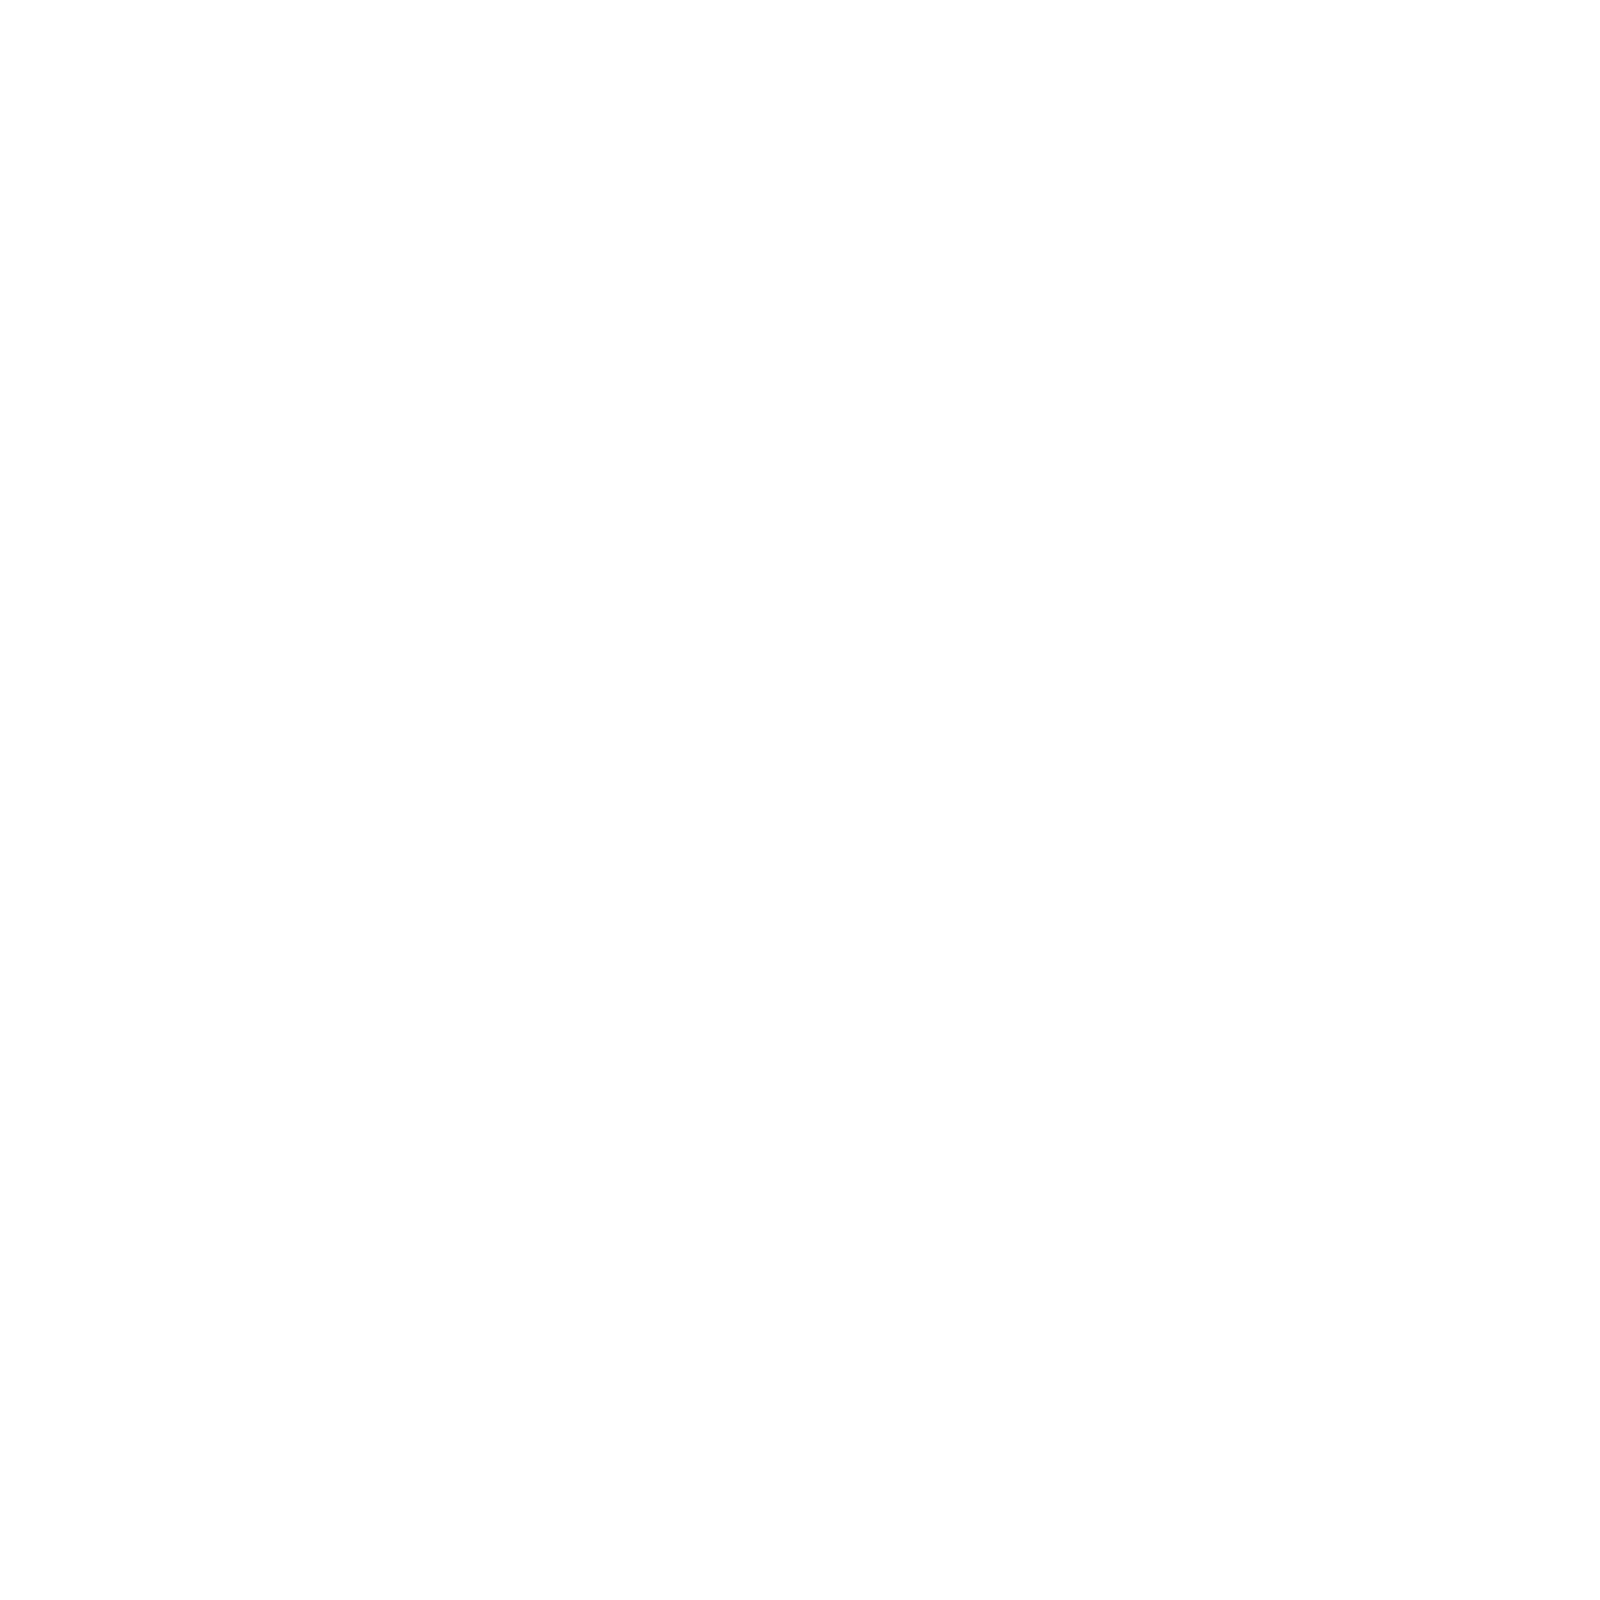

Scattered Light Subtraction:  99  %

Order Tracing:  98  %
 Scattered light subtraction and order tracing complete.


In [161]:
flat_frame, columns, order_centers, num_of_ords, orders, xx, yy = redux.scatter_light_sub_and_order_trace(flat_frame_intermed)

Let's inspect our bias and flat frames.

<IPython.core.display.Javascript object>


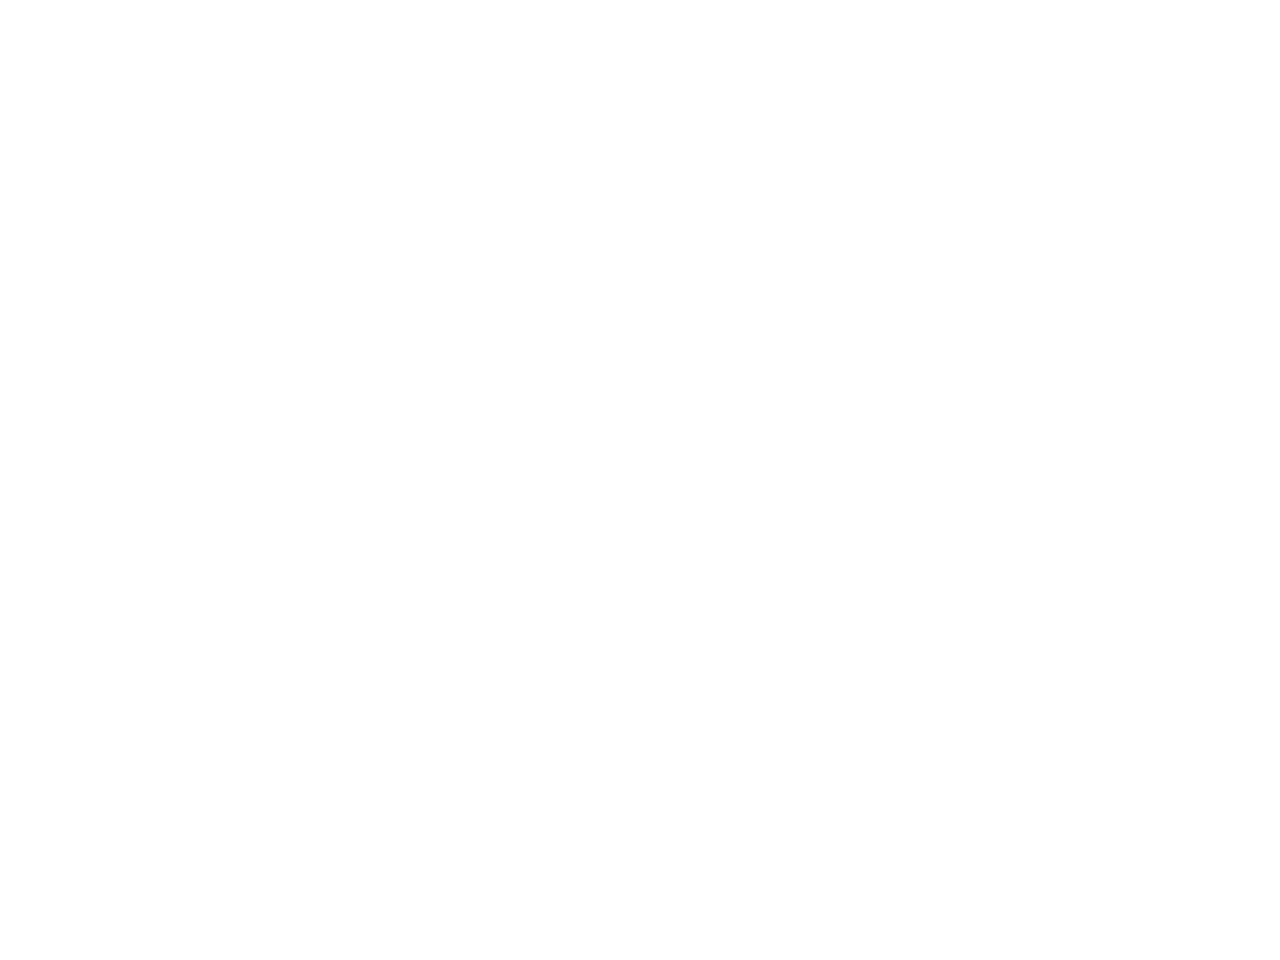

In [162]:
%matplotlib notebook
plt.figure()
plt.imshow(bias_frame, cmap='gist_earth_r', vmin=np.nanmedian(bias_frame)-5, vmax=np.nanmedian(bias_frame)+5)
plt.colorbar()
plt.title("BIAS FRAME: median = {a}, min = {b}, max = {c}".format(a=np.nanmedian(bias_frame), b=np.nanmin(bias_frame), c=np.nanmax(bias_frame)))
plt.show()

<IPython.core.display.Javascript object>


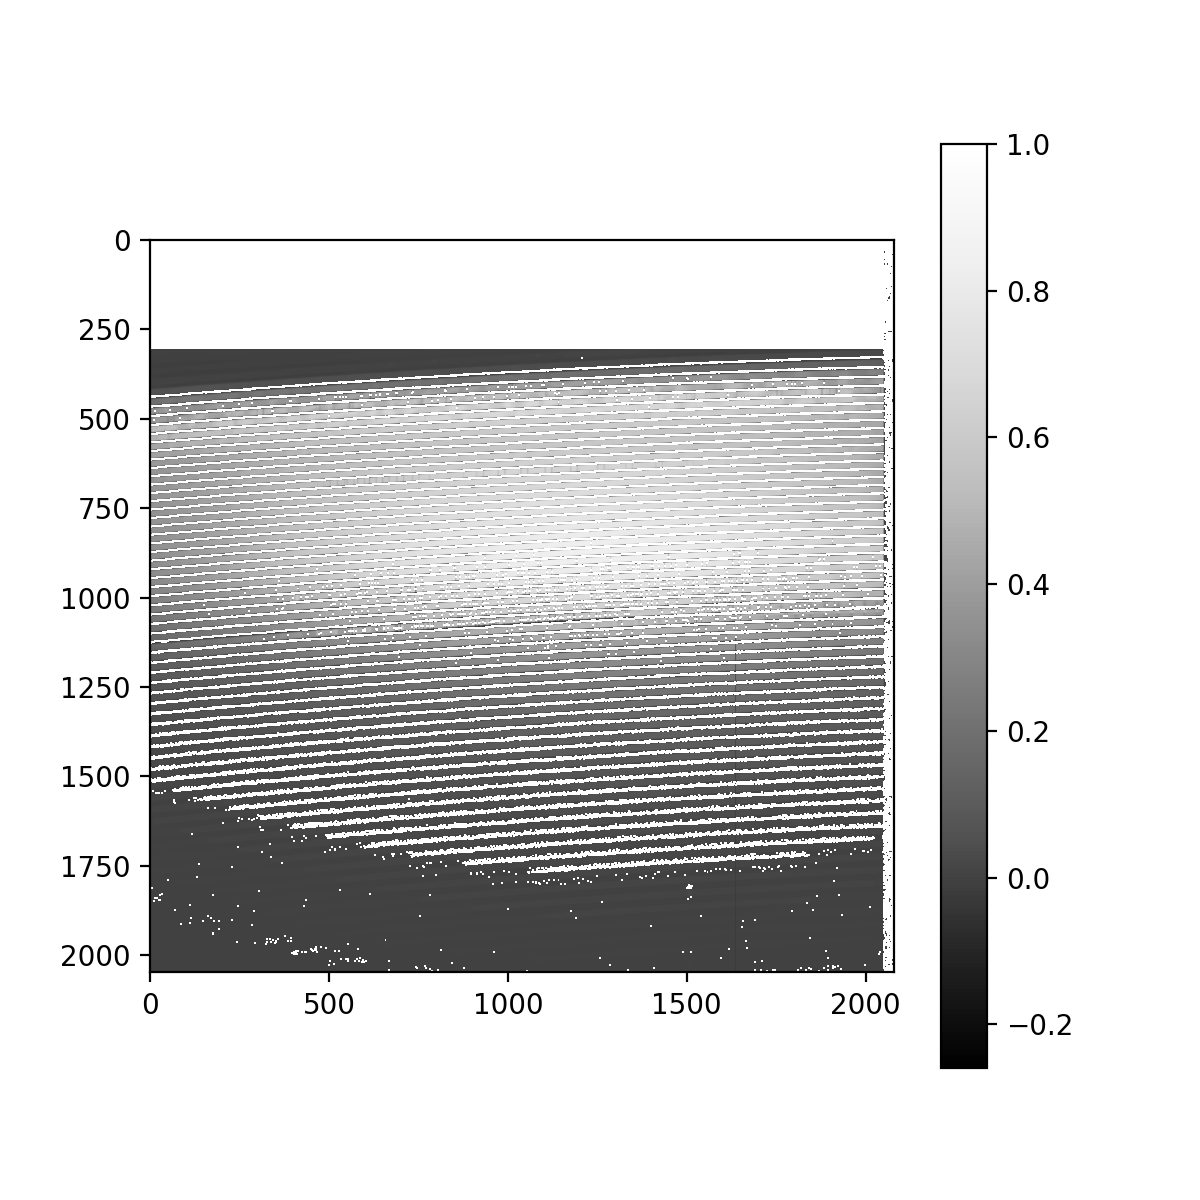

In [163]:
%matplotlib notebook

plt.figure(figsize=(6,6))
plt.imshow(flat_frame, cmap='Greys_r')
plt.colorbar()
#plt.title("FLAT FRAME: median = {a}, min = {b}, max = {c}".format(a=np.nanmedian(flat_frame), b=np.nanmin(flat_frame), c=np.nanmax(flat_frame)))
plt.show()

In [165]:
sun_pixels, sun_fluxes = redux.extract_obj_spec(sun_data[0], sun_objs[0], sun_exps[0], bias_frame, flat_frame, orders, num_of_ords)


Extracting 1d spectrum of  Solar Port
Finished extracting 1d spectrum of  Solar Port 



In [166]:
from astropy.table import Table
sun_waves = []
sun_ints = []
sun_ords = []
for ord in range(num_of_ords):
    sun_waves.append(sun_pixels[ord])
    sun_ints.append(sun_fluxes[ord])
    sun_ords.append(np.repeat(ord, len(sun_pixels[ord])))
t = Table([np.concatenate(sun_ords).ravel(), np.concatenate(sun_waves).ravel(), np.concatenate(sun_ints).ravel()], names=('Ord', 'Pix', 'Counts'))

<IPython.core.display.Javascript object>


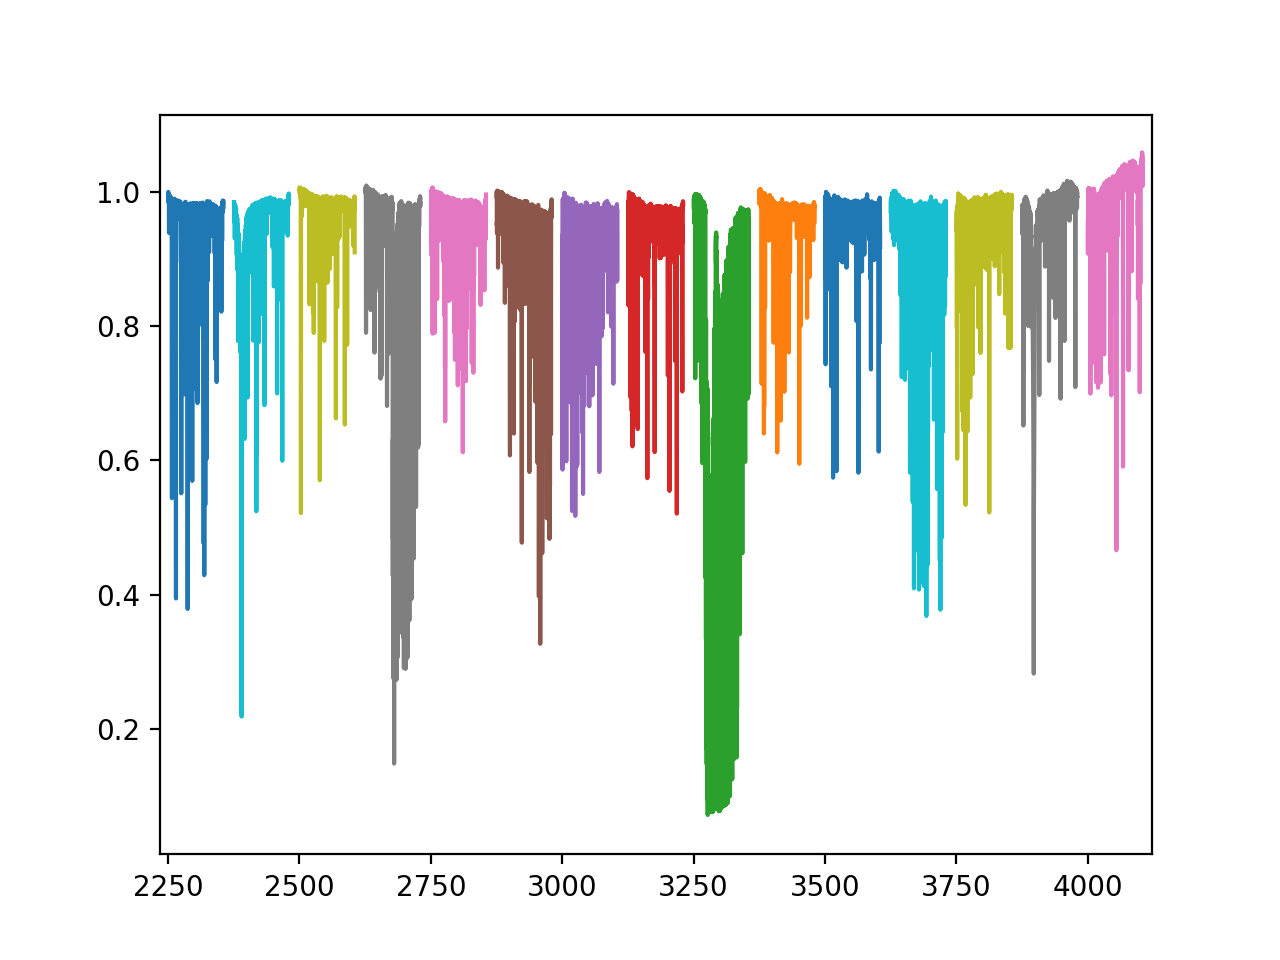

[4826.44475782 4713.42139333    0.            0.            0.
    0.         4002.01485128 3881.89802885 3753.96812231 3630.71578586
 3502.06625315 3375.42139333 3252.4774681  3127.01485128 3004.17372978
 2876.50083259 2855.07559894 2627.27186062 2604.92139333 2479.66438399
 2250.42139333    0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.        ] [339657.28011093 173674.11225935      0.              0.
      0.              0.         367498.40036703 424502.95260208
 483251.43876662 530076.76150222 565409.39384334 593494.43384621
 605628.04906853 616489.39015013 617761.21211921 615966.92512644
 611257.00938562 602571.59700811 591

In [156]:
#ORD = 25
v = -5
#R = 113400

# zack_sun = Table.read('/Users/catherinemanea/Box/GalArchLab/TullRedux/bacchus_ready_rv_cor_star0001_Twilight_UT220617_norm.txt', format='ascii')
# sol_fluxes = np.flip((t['Counts'][t['Ord'] == ORD]/np.nanmax(t['Counts'][t['Ord'] == ORD][:v]))[:v])

maxies = np.zeros(np.max(t['Ord']))
wavies = np.zeros(np.max(t['Ord']))
pix_full = []
plt.figure()
for ordi in range(np.max(t['Ord'])):
    sol_fluxes = np.flip(t['Counts'][t['Ord'] == ordi][5:v])
    sol_pixels = -ordi*125+(t['Pix'][t['Ord'] == ordi]*(5500/107000) + np.nanmin(zack_sun['waveobs']))[5:v]
    if (np.nanmax(sol_fluxes) < 800000):
        maxies[ordi] = np.nanmax(sol_fluxes)
        wavies[ordi] = sol_pixels[np.where(sol_fluxes == np.nanmax(sol_fluxes))]
        pix_full.append(sol_pixels)
#         plt.plot(sol_pixels, sol_fluxes)
z = np.polyfit(wavies[wavies>0], maxies[wavies>0], 7)   
p = np.poly1d(z)
# plt.scatter(wavies[wavies>0], maxies[wavies>0])
# plt.plot(np.concatenate(pix_full), p(np.concatenate(pix_full)))
for ordi in range(30):
    sol_fluxes = np.flip(t['Counts'][t['Ord'] == ordi][5:v])
    sol_pixels = -ordi*125+(t['Pix'][t['Ord'] == ordi]*(5500/107000) + np.nanmin(zack_sun['waveobs']))[5:v]
    plt.plot(sol_pixels, sol_fluxes/p(sol_pixels))
plt.show()

print(wavies, maxies)